# Zadanie domowe 5
## Wojciech Kretowicz

In [4]:
import openml
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, roc_auc_score

from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.externals.six import StringIO
import pydotplus

from sklearn.model_selection import RandomizedSearchCV

plt.rcParams['figure.figsize']=[25,17]

In [5]:
data = pd.read_csv('titanic.csv')

# Przygotowanie danych, kodowanie zmiennych

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Brakujące wartości

In [7]:
data.isna().sum()

Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

## Usunięcie imion

In [8]:
data = data.drop(columns=['Name'])

## Kodowanie OHE

In [9]:
data = pd.get_dummies(data, columns=['Sex'])

In [10]:
data.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


## Wizualizacja

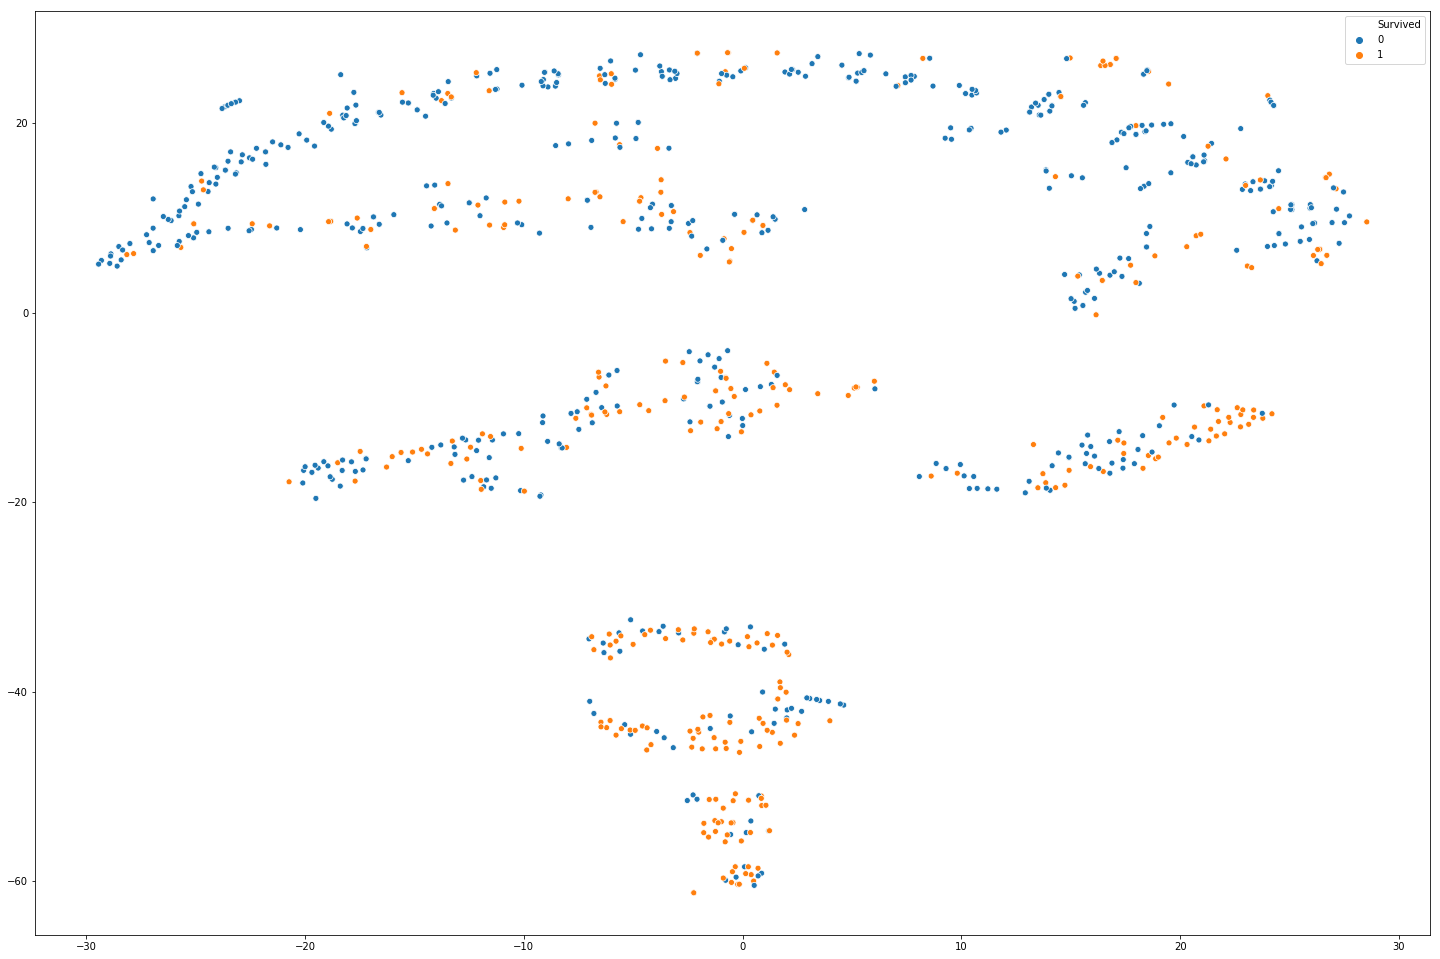

In [11]:
tsne = TSNE()
tsne.fit(data.drop(columns='Survived'))

sns.scatterplot(tsne.embedding_[:,0],tsne.embedding_[:,1],hue=data.Survived)
plt.show()

## Podział zbioru

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Survived'), data.Survived, random_state=1410)

# Wyniki dla różnych parametrów

## Klasyfikator dla parametrów z artykułu

Parametry wyszczególnione w pracy to:
* $cp = 0$
* $maxdepth=21$
* $minbucket=12$
* $minsplit=24$

### Z kryterium gini

In [13]:
dtc_art_gini = DecisionTreeClassifier(criterion='gini',max_depth=21, min_samples_split=24, min_samples_leaf=12)

dtc_art_gini.fit(X_train, y_train)

y_pred_art_gini = dtc_art_gini.predict(X_test)

### Z kryterium information gain

In [14]:
dtc_art_ent = DecisionTreeClassifier(criterion='entropy',max_depth=21, min_samples_split=24, min_samples_leaf=12)

dtc_art_ent.fit(X_train, y_train)

y_pred_art_ent = dtc_art_ent.predict(X_test)

## Klasyfikator dla parametrów domyślnych pakietu sklearn

In [15]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_def = dtc.predict(X_test)

## Klasyfikator z parametrami znalezionymi dzięki random search

In [16]:
dtc_rs = DecisionTreeClassifier()

In [17]:
param_dist = {'criterion': ['gini','entropy'],
             'max_depth': np.arange(1,101),
             'min_samples_split': np.arange(2,101),
             'min_samples_leaf': np.arange(1,101)}

rs = RandomizedSearchCV(dtc_rs,param_dist,1000,'roc_auc', n_jobs=10)

rs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=10,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': array([  1,   2, ...,  99, 100]), 'min_samples_split': array([  2,   3, ...,  99, 100]), 'min_samples_leaf': array([  1,   2, ...,  99, 100])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [18]:
dtc_rs.set_params(**rs.best_params_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=13,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
dtc_rs.fit(X_train,y_train)

y_pred_rs = dtc_rs.predict(X_test)

# Porównanie

## Macierze pomyłek

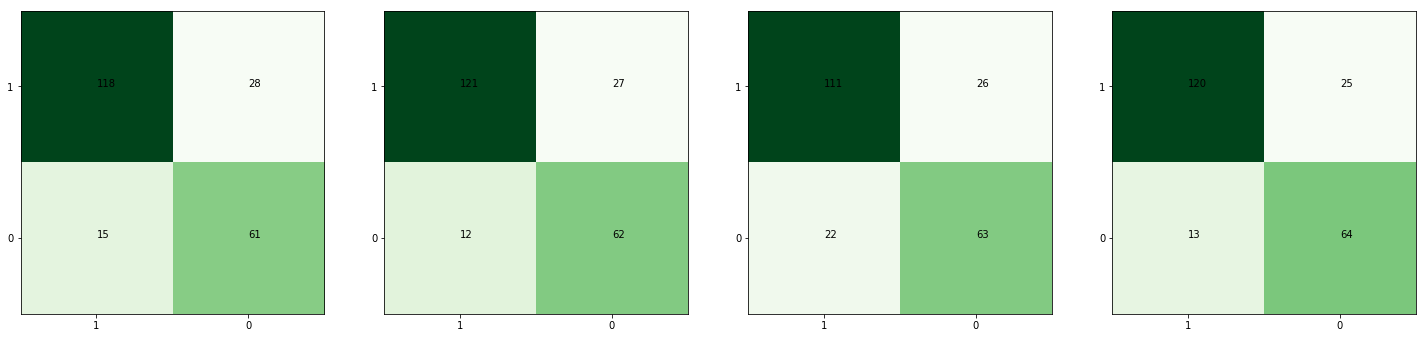

In [20]:
cm1 = confusion_matrix(y_test, y_pred_art_gini)
cm2 = confusion_matrix(y_test, y_pred_art_ent)
cm3 = confusion_matrix(y_test, y_pred_def)
cm4 = confusion_matrix(y_test, y_pred_rs)

fig, ax = plt.subplots(1,4)

plt.setp(ax,xticks=[0,1], xticklabels=[1,0],yticks=[0,1], yticklabels=[1,0])

ax[0].imshow(cm1, interpolation='nearest', cmap=plt.cm.Greens)

ax[0].text(0,0,cm1[0][0])
ax[0].text(1,0,cm1[1][0])
ax[0].text(0,1,cm1[0][1])
ax[0].text(1,1,cm1[1][1])

ax[1].imshow(cm2, interpolation='nearest', cmap=plt.cm.Greens)

ax[1].text(0,0,cm2[0][0])
ax[1].text(1,0,cm2[1][0])
ax[1].text(0,1,cm2[0][1])
ax[1].text(1,1,cm2[1][1])

ax[2].imshow(cm3, interpolation='nearest', cmap=plt.cm.Greens)

ax[2].text(0,0,cm3[0][0])
ax[2].text(1,0,cm3[1][0])
ax[2].text(0,1,cm3[0][1])
ax[2].text(1,1,cm3[1][1])

ax[3].imshow(cm4, interpolation='nearest', cmap=plt.cm.Greens)

ax[3].text(0,0,cm4[0][0])
ax[3].text(1,0,cm4[1][0])
ax[3].text(0,1,cm4[0][1])
ax[3].text(1,1,cm4[1][1])

plt.show()

## Miary

In [21]:
y_pred = [y_pred_art_gini, y_pred_art_ent, y_pred_def, y_pred_rs]

estimator = ['ARTICLE GINI', 'ARTICLE ENTROPY', 'PACKAGE DEFAULT', 'RANDOM SEARCH']
metric = ['accuracy', 'auc', 'mse']
accuracy = [accuracy_score(y_test,Y) for Y in y_pred]
auc = [roc_auc_score(y_test,Y) for Y in y_pred]
mse = [mean_absolute_error(y_test,Y) for Y in y_pred]

results = pd.DataFrame({'estimator': estimator,'accuracy': accuracy, 'auc': auc, 'mse': mse})

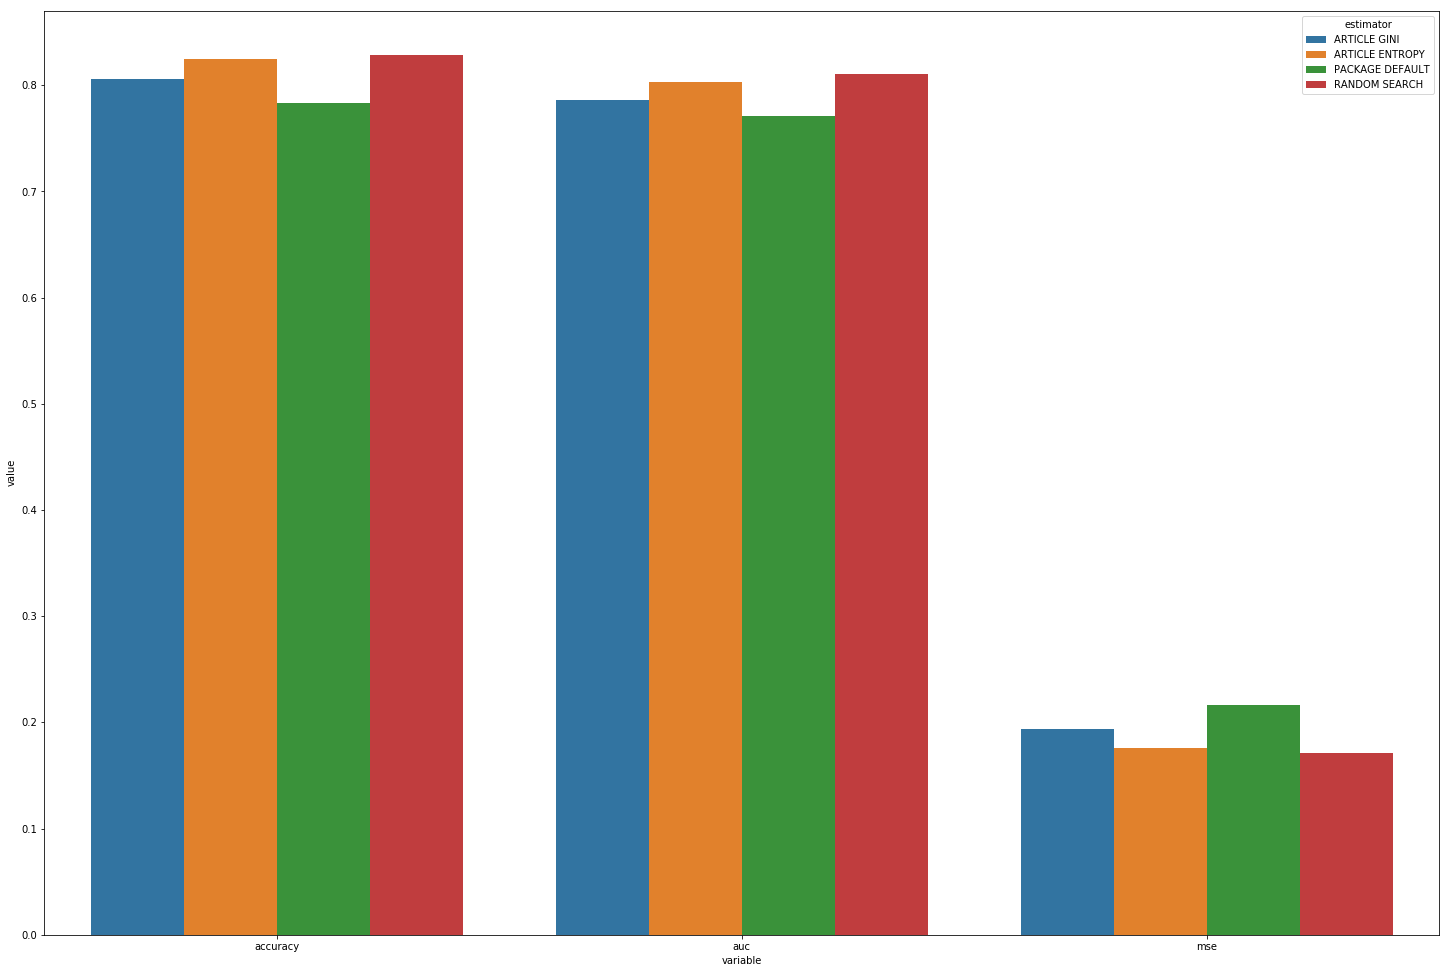

In [38]:
sns.barplot(x='variable', y='value', hue='estimator',data=results.melt(id_vars=['estimator']))
plt.show()

In [ ]:
sns.catplot(x = 'metric', y='estim')

# Wizualizacje drzew

## Drzewo gini

'dot' is not recognized as an internal or external command,
operable program or batch file.


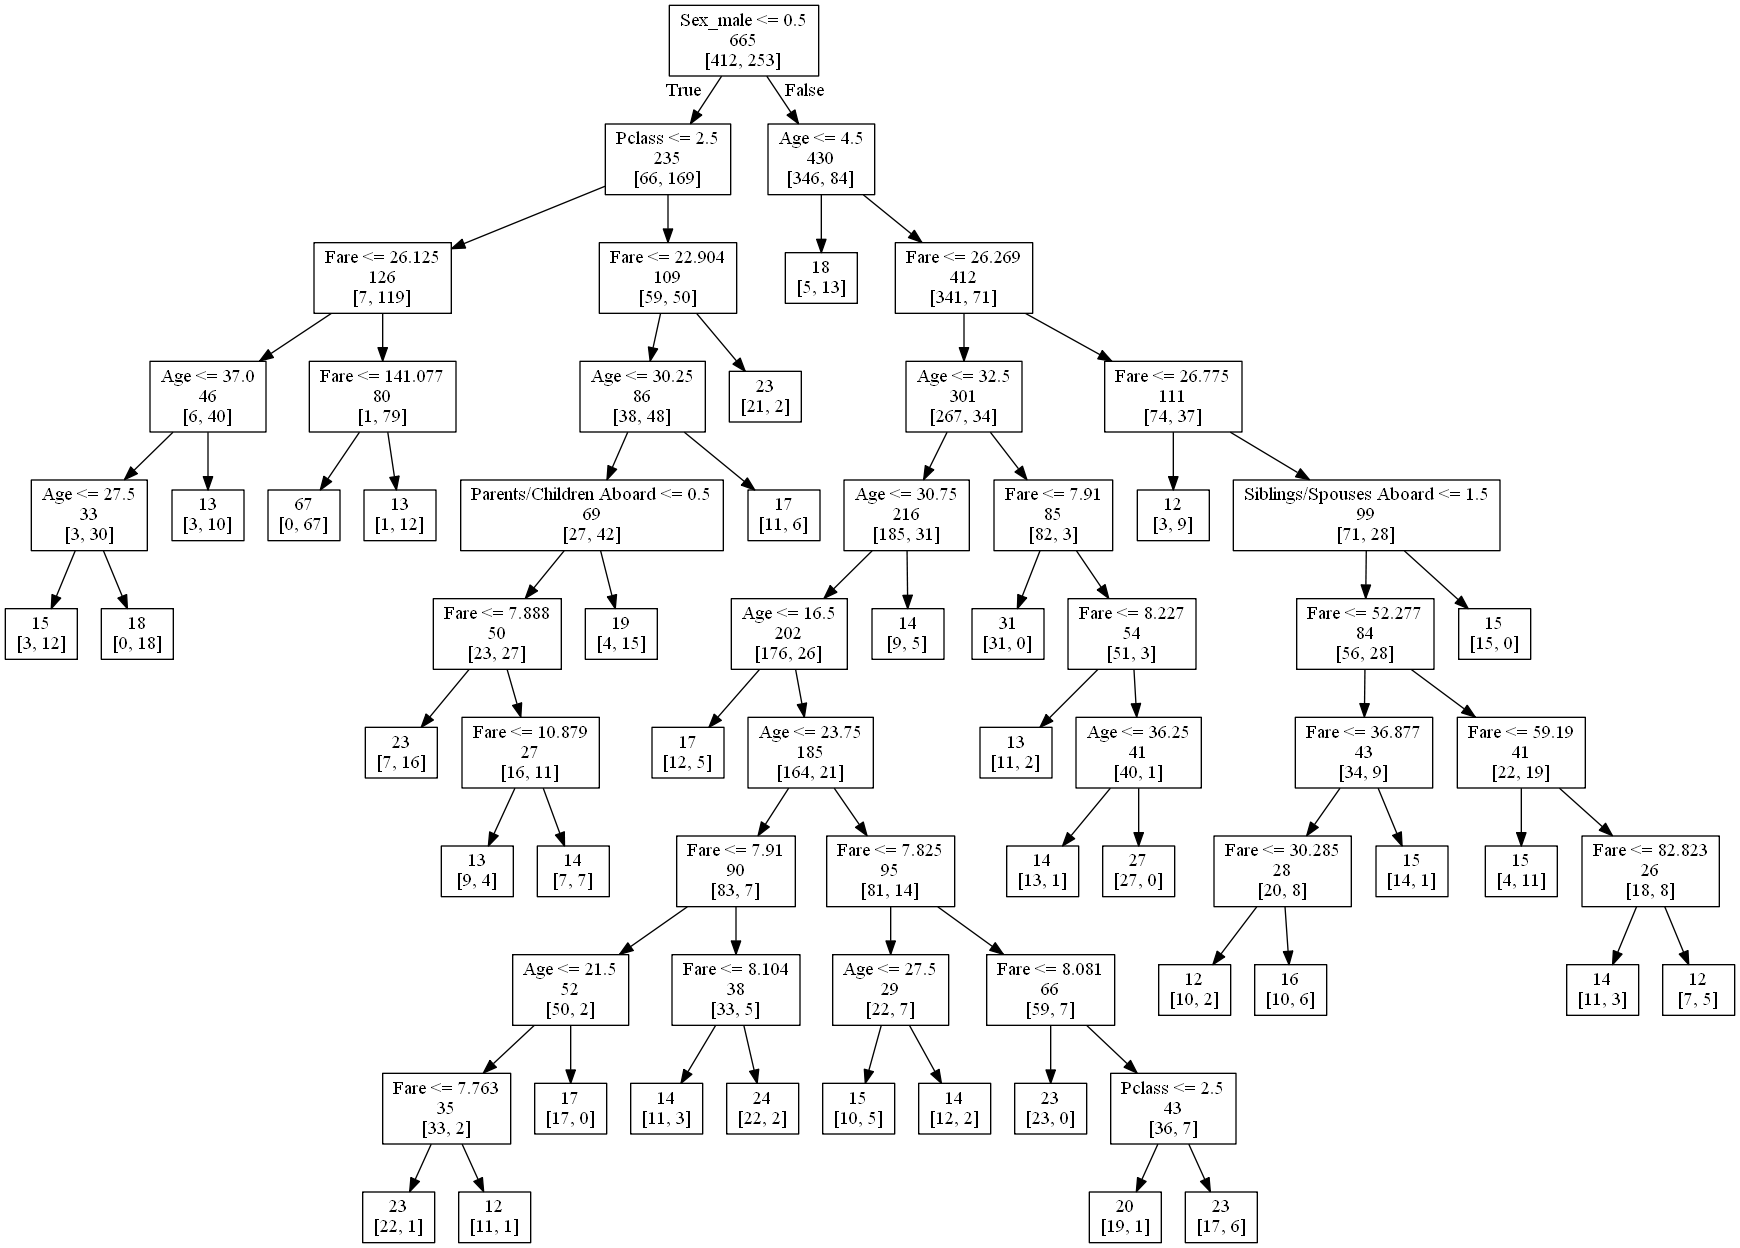

In [28]:
export_graphviz(dtc_art_gini,out_file='gini.dot', feature_names=X_train.columns, label=None, impurity=False)
! dot -Tpng gini.dot -o gini.png 
figure = Image(filename='gini.png')
display(figure)

## Drzewo entropy

'dot' is not recognized as an internal or external command,
operable program or batch file.


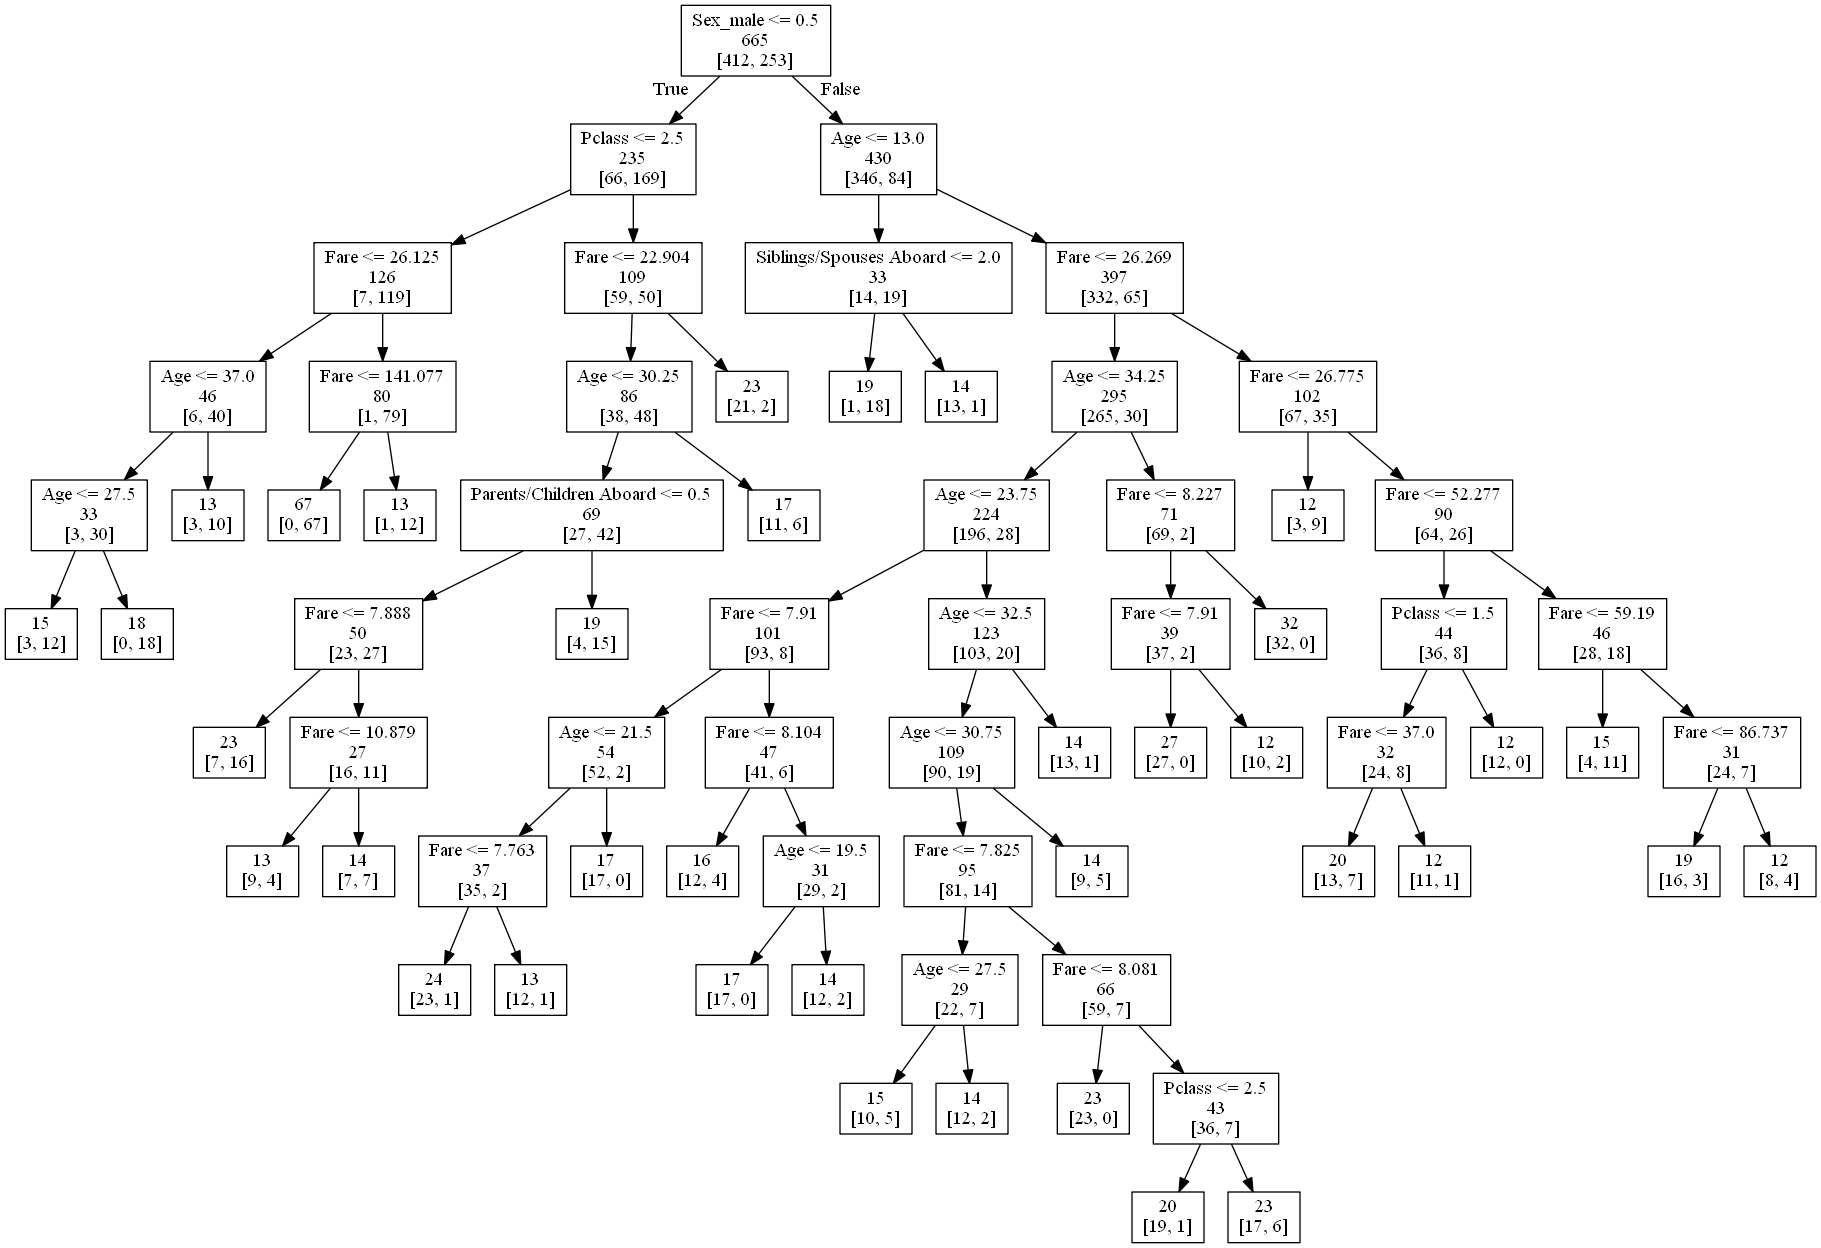

In [33]:
export_graphviz(dtc_art_ent,out_file='ent.dot', feature_names=X_train.columns, label=None, impurity=False)
!dot -Tpng ent.dot -o ent.png 
figure = Image(filename='ent.png')
display(figure)

# Wnioski

* Parametry podane w artykule dają rezultaty bliskie parametrom optymalnym.
* Entropy (information gain) dla tego zbioru ogółem radzi sobie lepiej od gini.
* Parametry domyślne pakietu sklearn dają rezultaty ogółem gorsze, chociaż dla błędu $mse$ lepsze.